In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import clear_output, display
import time
from pathlib import Path
import copy

import proper
proper.prop_use_fftw(DISABLE=False)

import roman_phasec_proper

import cgi_phasec_poppy as cgi
import cgi_phasec_poppy.imshows as imshows
from cgi_phasec_poppy.imshows import *

import h5py

from importlib import reload

# data_dir = Path('/groups/douglase/kians-data-files/disk-processing')
data_dir = Path('/npool/nvme/kianmilani/disk-data')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix
print(psf_pixelscale_lamD, psf_pixelscale_mas)

iwa = 2.8
owa = 9.7

0.43478260869565216 21.821421675669278 mas / pix


21.737714120425565


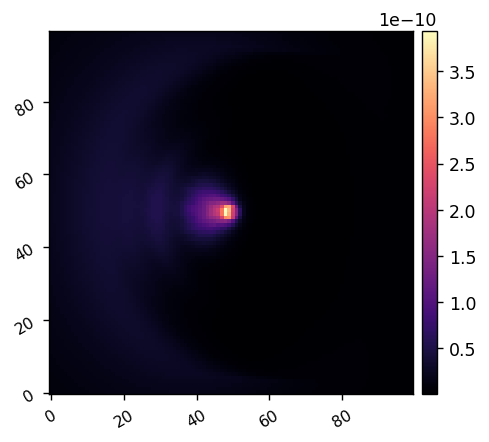

In [2]:
disk = fits.getdata(data_dir/'disks'/'I_0_eps_eri.fits')

ndisk = 100
disk_pixelscale_mas = 21.82*u.mas/u.pix
disk_extent = ndisk/2*disk_pixelscale_mas/mas_per_lamD
print(disk_extent.value)

disk = utils.pad_or_crop(disk, ndisk) # crop it to our region of interest
imshow1(disk)

0.43478260869565216 21.821421675669278


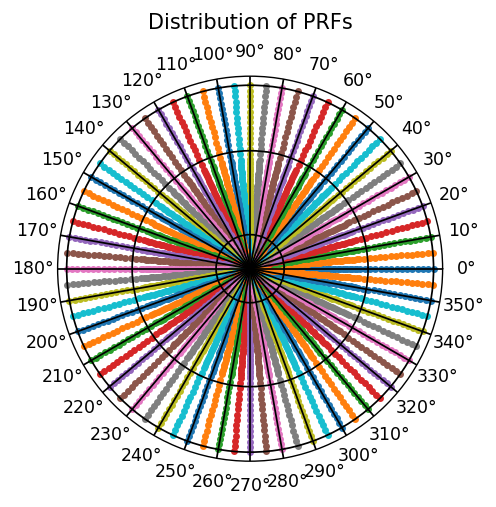

In [15]:
polaxis = -2

psfs = fits.getdata(data_dir/'psfs'/f'hlc_band1_psfs_polaxis{polaxis:d}_20240418.fits')
psfs_hdr = fits.getheader(data_dir/'psfs'/f'hlc_band1_psfs_polaxis{polaxis:d}_20240418.fits')
print(psfs_hdr['PXSCLAMD'], psfs_hdr['PXSCLMAS'])

r_offsets = fits.getdata(data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20240418.fits')
thetas = fits.getdata(data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20240418.fits')*u.deg

npsf = psfs.shape[1]

theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(4,4))

ax1 = plt.subplot(111, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.', )
ax1.set_yticklabels([])
ax1.set_rticks([iwa, owa, max(r_offsets)],)  # Less radial ticks
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.set_thetagrids(thetas[::2].value)
ax1.grid(axis='x', visible=True, color='black', linewidth=1)
ax1.grid(axis='y', color='black', linewidth = 1)
ax1.set_title('Distribution of PRFs', va='bottom')
ax1.set_axisbelow(False)

In [3]:
r_offsets_mas = r_offsets * mas_per_lamD

def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    if kr>(len(r_offsets)-1):
        kr = len(r_offsets)-1
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: 
        kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=1)
    
    return interpped_psf

Desired r=10.04 mas, radial index=1, closest available r=10.04 mas
Desired th=325.00 deg, theta index=65, closest available th=325.00 deg, difference=0.00 deg
PSF index = 66


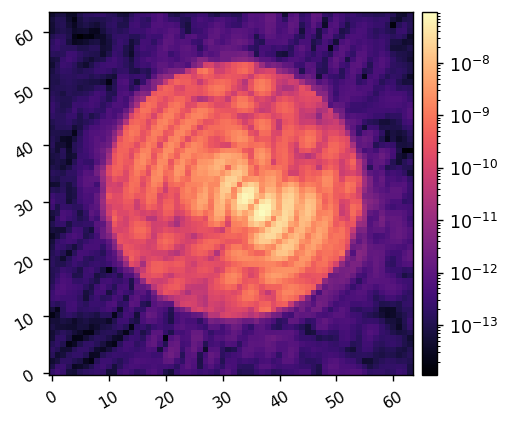

Desired r=10.04 mas, radial index=1, closest available r=10.04 mas
Desired th=330.00 deg, theta index=66, closest available th=330.00 deg, difference=-0.00 deg
PSF index = 67


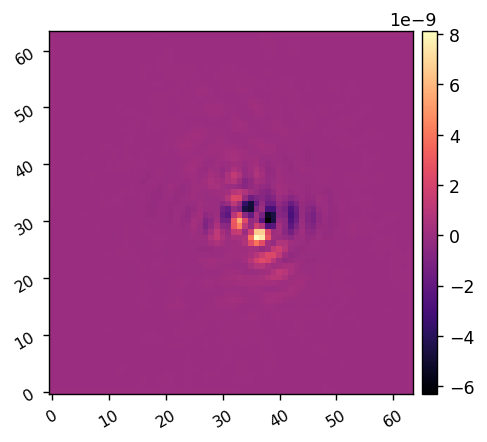

In [34]:
r = 0.2*mas_per_lamD
th = 325.0*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf1 = find_closest_psf(xoff,yoff)

imshow1(psf1, lognorm=True)

r = 0.2*mas_per_lamD
th = 330.0*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf2 = find_closest_psf(xoff,yoff)

imshow1(psf1-psf2,)

In [12]:
ndisk = 100
disk_pixelscale_mas = 21.82*u.mas/u.pix
disk_extent = ndisk/2*disk_pixelscale_mas/mas_per_lamD
print(disk_extent.value)

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

21.737714120425565


<Quantity [-1080.09, -1058.27, -1036.45, ...,  1036.45,  1058.27,  1080.09] mas>

In [16]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

9999 5.9730987548828125


In [17]:
ipsf_fpath = data_dir/'ipsfs'/f'hlc_band1_ipsfs_polaxis{polaxis:d}_may2024.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()

# Demonstrate a simulation

In [3]:
polaxis = -2
ipsf_fpath = data_dir/'ipsfs'/f'hlc_band1_ipsfs_polaxis{polaxis:d}_may2024.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

In [27]:
ipsf_matrix.shape

(4096, 10000)

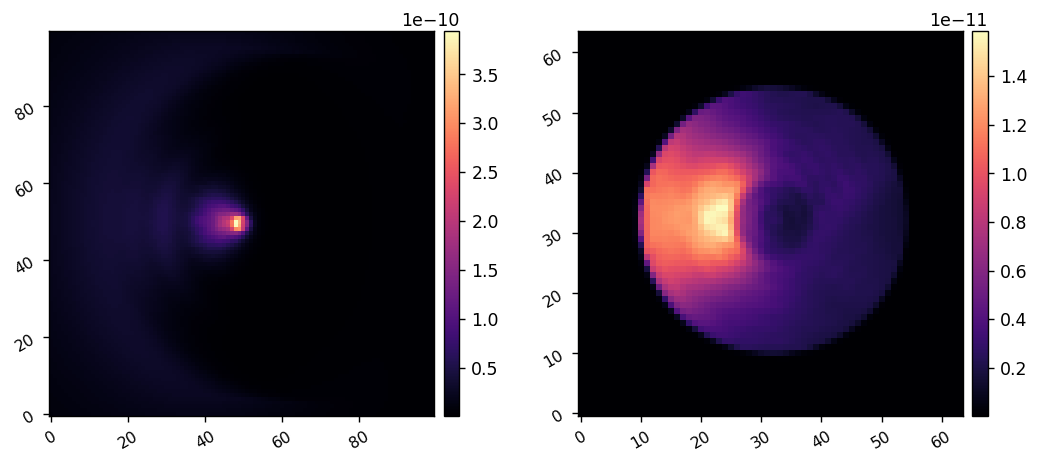

In [30]:
disk_image = ipsf_matrix.dot(disk.ravel()).reshape(npsf,npsf)
imshow2(disk, disk_image)

In [4]:
polaxis = -2
ipsf_fpath = data_dir/'ipsfs'/f'hlc_band1_ipsfs_polaxis{polaxis:d}_may2024.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix_n2 = np.array(f['ipsf_matrix'])
f.close()

polaxis = 2
ipsf_fpath = data_dir/'ipsfs'/f'hlc_band1_ipsfs_polaxis{polaxis:d}_may2024.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix_p2 = np.array(f['ipsf_matrix'])
f.close()

npsf = int(np.sqrt(ipsf_matrix_n2.shape[0]))

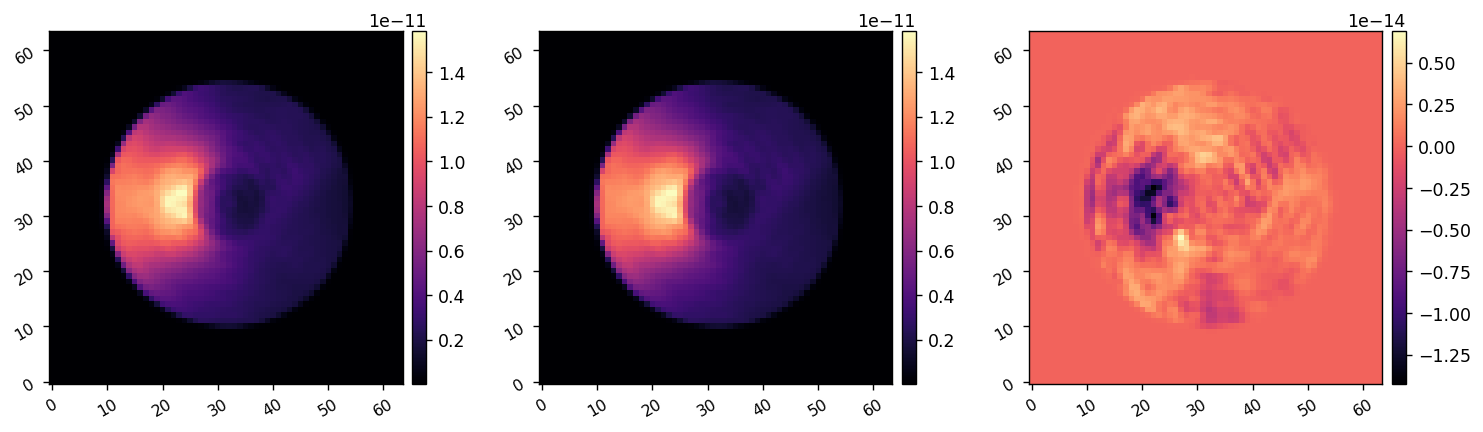

In [10]:
disk_image_n2 = ipsf_matrix_n2.dot(disk.ravel()).reshape(npsf,npsf)
disk_image_p2 = ipsf_matrix_p2.dot(disk.ravel()).reshape(npsf,npsf)
diff = disk_image_n2-disk_image_p2
imshow3(disk_image_n2, disk_image_p2, diff)